#  How to create a simple People Counter Application using Panorama SDK

**Goal of this Notebook** :

* Aid an Panorama developer prototype their application before creating the AWS Lambda for Panorama
* Using the built in wrapper application that **mimics** the Panorama sdk to get inference from the model
* Create and Deploy the AWS Lambda for Panorama from this notebook

**What this Notebook accomplishes?** :
* Detect People in a selected video
* Draw bounding boxes around the people
* Count the number of people detected
* Display the count on the video frames


**Useful Resources to aid your development**:
* [AWS Panorama Documentation](https://docs.aws.amazon.com/panorama/)



**CAUTION PLEASE READ BEFORE PROCEEDING** :

* The panoramasdk wrapper class used in this demo is not the original Panorama sdk that is on the device image
* The wrapper class does not reflect the capabilities of the original Panorama SDK on the device
* Its sole purpose is to give a developer a realistic idea of the structure and signature of the sdk on the device

**Pre -Requisites**:
* Sagemaker Instance created with the right role (Policies needed IOT, Lambda and S3, IAM Full Access) 



**Frames to Process**:

* By default, we only process 10 frames from the video. If you want to increase this, please change this value in /panorama_sdk/panoramasdk.py and change frames_to_process = 10 to a value of your choice

#### Video to use

In [1]:
video_to_use = "TownCentreXVID.avi"

#### Step 1: Import Non Panorama Libraries

In [2]:
!pip3 install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [3]:
from __future__ import division
from __future__ import print_function

from IPython.display import clear_output, Markdown, display
import json

from gluoncv import model_zoo, data, utils
import mxnet as mx

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

#### Import required roles

In [4]:
import sagemaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

#### Step 2: Modelling Approach

This step walks through using the Panorama SDK (wrapper) model to get inference

* **Model** : ssd_512_resnet50_v1_voc
* **Dataset** : These models are trained on [PascalVOC](http://host.robots.ox.ac.uk/pascal/VOC/) datasets with 20 classes of objects  
* **arXiv** :[Application of Convolutional Neural Network for Image
Classification on Pascal VOC Challenge 2012 dataset](https://arxiv.org/pdf/1607.03785.pdf)  
* **Model Input Size** : 512 x 512  
* **Model Output** : (1, 100, 1), (1,100,1), (1,100,4)

##### **A. Loading the model**

In [5]:
import os
import sys
path = os.path.abspath(os.path.join(os.path.dirname("panorama_sdk"), '../..'))
sys.path.insert(1, path + '/panorama_sdk')

import panoramasdk
import jupyter_utils

print('Loading Model')
model = panoramasdk.model()
model.open('ssd_512_resnet50_v1_voc', 1)
print('Model Loaded')

Loading Model
Model Loaded


##### **B. Pre Processing**

In [6]:
def preprocess(img, size):

    resized = cv2.resize(img, (size, size))
    mean = [0.485, 0.456, 0.406]  # RGB
    std = [0.229, 0.224, 0.225]  # RGB

    img = resized.astype(np.float32) / 255.  # converting array of ints to floats
    img_a = img[:, :, 0]
    img_b = img[:, :, 1]
    img_c = img[:, :, 2]

    # Extracting single channels from 3 channel image
    # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)
    # normalizing per channel data:
    img_a = (img_a - mean[0]) / std[0]
    img_b = (img_b - mean[1]) / std[1]
    img_c = (img_c - mean[2]) / std[2]

    # putting the 3 channels back together:
    x1 = [[[], [], []]]
    x1[0][0] = img_a
    x1[0][1] = img_b
    x1[0][2] = img_c
    x1 = np.asarray(x1)

    return x1

##### **C. Inference**

In [7]:
import cv2
import numpy as np


## Panorama has a unique signature where we have to create empty arrays with the output dimensions before hand

# Create input and output arrays.
class_info = model.get_output(0)
prob_info = model.get_output(1)
rect_info = model.get_output(2)

class_array = np.empty(class_info.get_dims(), dtype=class_info.get_type())
prob_array = np.empty(prob_info.get_dims(), dtype=prob_info.get_type())
rect_array = np.empty(rect_info.get_dims(), dtype=rect_info.get_type())

person_image = cv2.imread('street_empty.jpg')

# Pre Process Frame
x1 = preprocess(person_image, 512)

# Do inference on the new frame.
model.batch(0, x1)
model.flush()

# Get the results.
resultBatchSet = model.get_result()

class_batch = resultBatchSet.get(0)
prob_batch = resultBatchSet.get(1)
rect_batch = resultBatchSet.get(2)

class_batch.get(0, class_array)
prob_batch.get(1, prob_array)
rect_batch.get(2, rect_array)

class_data = class_array
prob_data = prob_array
rect_data = rect_array


print('Class data shape is ', class_data.shape)
print('Confidence data shape is ', prob_data.shape)
print('Bounding Boxes data shape is ',rect_data.shape)

Class data shape is  (1, 100, 1)
Confidence data shape is  (1, 100, 1)
Bounding Boxes data shape is  (1, 100, 4)


#### Step 3 : Understanding and creating the Structure of the Application

The Panorama Lambda function has the following structure

In [8]:
### Lambda skeleton


class people_counter(object):
    def interface(self):
        # defines the parameters that interface with other services from Panorama
        return

    def init(self, parameters, inputs, outputs):
        # defines the attributes such as arrays and model objects that will be used in the application
        return

    def entry(self, inputs, outputs):
        # defines the application logic responsible for predicting using the inputs and handles what to do
        # with the outputs
        return

#### Step 4 : Let us use the panoramasdk wrapper function to simulate a real Panorama device lambda

In [9]:
jupyter_utils.change_video_source(video_to_use)

Video Changed to TownCentreXVID.avi


In [10]:
import panoramasdk
import cv2
import numpy as np
import time
import boto3

# [AWS Panorama Documentation](https://docs.aws.amazon.com/panorama/)


HEIGHT = 512
WIDTH = 512

class people_counter(panoramasdk.base):
    
    def interface(self):
        return {
                "parameters":
                (
                    ("float", "threshold", "Detection threshold", 0.10),
                    ("model", "person_detection", "Model for detecting persons", "ssd_512_resnet50_v1_voc"), 
                    ("int", "batch_size", "Model batch size", 1),
                    ("float", "person_index", "person index based on dataset used", 14),
                ),
                "inputs":
                (
                    ("media[]", "video_in", "Camera input stream"),
                ),
                "outputs":
                (
                    ("media[video_in]", "video_out", "Camera output stream"),
                    
                ) 
            }
    
    
    """init() function is called once by the Lambda runtime.  It gives Lambda a chance to perform 
    any necessary initialization before entering the main loop."""
        
    def init(self, parameters, inputs, outputs):  
        try:  
            """panoramasdk.model : Creates an Panorama.model object."""
            
            print('Loading Model')
            self.model = panoramasdk.model()
            self.model.open(parameters.person_detection, 1)
            print('Model Loaded')
            
            # Detection probability threshold.
            self.threshold = parameters.threshold
            # Frame Number Initialization
            self.frame_num = 0
            # Number of People
            self.number_people = 0
            # Bounding Box Colors
            self.colours = np.random.rand(32, 3)
            # Person Index for Model from parameters
            self.person_index = parameters.person_index
            # Set threshold for model from parameters 
            self.threshold = parameters.threshold
            
            """model.get_output : Return a model.output_array object that represents output of the model."""
            
            class_info = self.model.get_output(0)
            prob_info = self.model.get_output(1)
            rect_info = self.model.get_output(2)

            self.class_array = np.empty(class_info.get_dims(), dtype=class_info.get_type())
            self.prob_array = np.empty(prob_info.get_dims(), dtype=prob_info.get_type())
            self.rect_array = np.empty(rect_info.get_dims(), dtype=rect_info.get_type())

            return True
        
        except Exception as e:
            print("Exception: {}".format(e))
            return False

    def preprocess(self, img, size):
        
        resized = cv2.resize(img, (size, size))
        mean = [0.485, 0.456, 0.406]  # RGB
        std = [0.229, 0.224, 0.225]  # RGB
        
        img = resized.astype(np.float32) / 255.  # converting array of ints to floats
        img_a = img[:, :, 0]
        img_b = img[:, :, 1]
        img_c = img[:, :, 2]
        
        # Extracting single channels from 3 channel image
        # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)
        # normalizing per channel data:
        img_a = (img_a - mean[0]) / std[0]
        img_b = (img_b - mean[1]) / std[1]
        img_c = (img_c - mean[2]) / std[2]
        
        # putting the 3 channels back together:
        x1 = [[[], [], []]]
        x1[0][0] = img_a
        x1[0][1] = img_b
        x1[0][2] = img_c
        x1 = np.asarray(x1)
        
        return x1
    
    def get_number_persons(self, class_data, prob_data):
        
        # get indices of people detections in class data
        person_indices = [i for i in range(len(class_data)) if int(class_data[i]) == self.person_index]
        # use these indices to filter out anything that is less than 95% threshold from prob_data
        prob_person_indices = [i for i in person_indices if prob_data[i] >= self.threshold]
        return prob_person_indices
    
    
    """entry() function is called by the Lambda runtime from the main loop whenever there’s input data available for processing. 
    The job of the  entry() function is to process the input data as fast as possible, generate and assign outputs as required by a particular algorithm, 
    and return back to the main loop. """
    
    def entry(self, inputs, outputs):
        self.frame_num += 1
        
        for i in range(len(inputs.video_in)):
            
            
            stream = inputs.video_in[i]
            
            """numpy.array that contains the latest stream image data."""
            
            person_image = stream.image
            w, h, c = person_image.shape

            # Pre Process Frame
            x1 = self.preprocess(person_image, 512)
                                    
            # Do inference on the new frame.
            
            """
            model.batch 
            
            *Returns: *None*.*
            *Parameter:*

            * *input_idx (int):* One model might provide multiple inputs. This index represents the specific input model.
            * *input_data_array (numpy.array):* The actual array data that you want to send for inference.

            """
            
            self.model.batch(0, x1)
            
            """model.flush : An unblocking call that sends all input data provided through .batch(input_idx, input_data_array) to make inference."""
            
            self.model.flush()
            
            """model.get_result : Gets inference results."""
            
            resultBatchSet = self.model.get_result()
            
            """.get : Gets data from specific index of a batched output array. """
            
            class_batch = resultBatchSet.get(0)
            prob_batch = resultBatchSet.get(1)
            rect_batch = resultBatchSet.get(2)

            class_batch.get(0, self.class_array)
            prob_batch.get(1, self.prob_array)
            rect_batch.get(2, self.rect_array)

            class_data = self.class_array[0]
            prob_data = self.prob_array[0]
            rect_data = self.rect_array[0]
            
            
            # Get Indices of classes that correspond to People
            person_indices = self.get_number_persons(class_data, prob_data)
            
            try:
                self.number_people = len(person_indices)
            except:
                self.number_people = 0
            
            # Visualize with Opencv or stream.(media) 
            
            if self.number_people > 0:
                for index in person_indices:
                    
                    left = np.clip(rect_data[index][0] / np.float(HEIGHT), 0, 1)
                    top = np.clip(rect_data[index][1] / np.float(WIDTH), 0, 1)
                    right = np.clip(rect_data[index][2] / np.float(HEIGHT), 0, 1)
                    bottom = np.clip(rect_data[index][3] / np.float(WIDTH), 0, 1)
                    
                    
                    """Add_Rect, Add_label : Adds text label aand nnotations to the data stream."""
                    
                    stream.add_rect(left, top, right, bottom)
                    stream.add_label(str(prob_data[index][0]), right, bottom) 
                    
                    
     
            stream.add_label('Number of People : {}'.format(self.number_people), 0.1, 0.1)
        
            """.release_result : Releases the inference result reference and frees up the data slot for reuse. 
            The model inference loop removes the inference result data that was buffered."""
            
            self.model.release_result(resultBatchSet)
            
            outputs.video_out[i] = stream
            

            
        return True

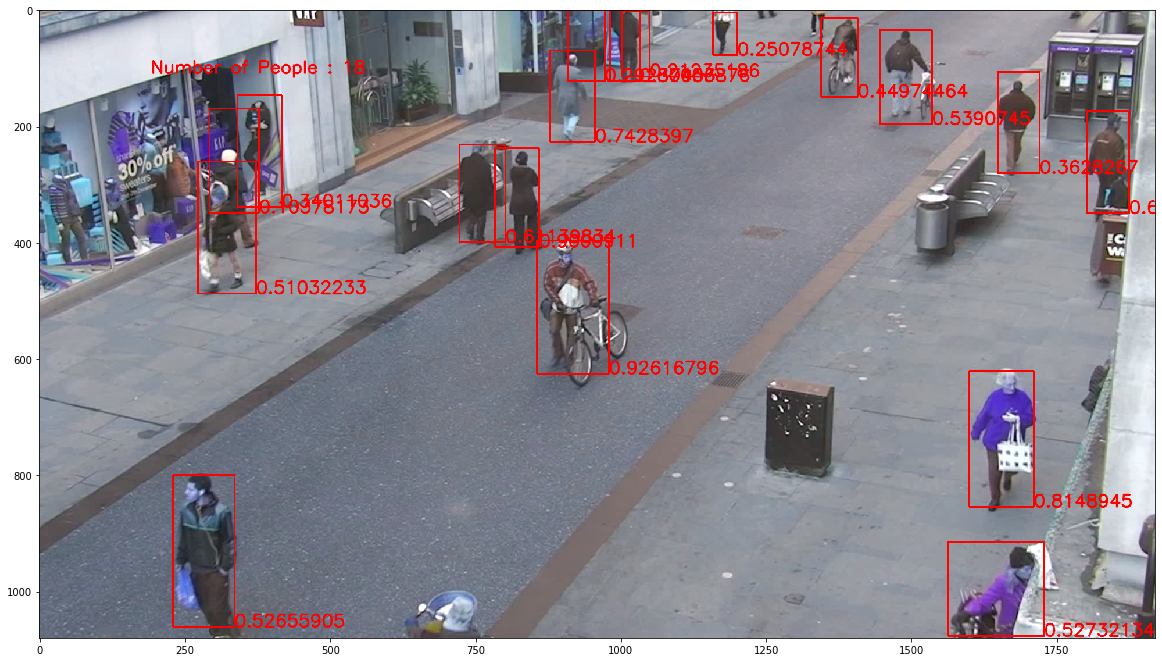

In [11]:
def main():
    """run() member function is implemented in the Lambda base class. It performs Lambda initialization and enters the main loop."""
    
    people_counter().run()
main()

#### Step 5 : Upload Lambda and Create Lambda Function

* A lambda is already provided and ready for use in the lambda folder (zip file)
* Use this code snippet to upload and publish it to Lambda Service


This Python snippet uses boto3 to create an IAM role named LambdaBasicExecution with basic 
lambda execution permissions.

In [ ]:
role_policy_document = {
    "Version": "2012-10-17",
    "Statement":[
        {
            "Effect": "Allow",
            "Principal": {"Service": ["lambda.amazonaws.com", "events.amazonaws.com"]},
            "Action": "sts:AssumeRole",
        }
    ]
}

iam_client = boto3.client("iam")

iam_client.create_role(
    RoleName="PeopleCounterExecutionRole",
    AssumeRolePolicyDocument=json.dumps(role_policy_document),
)

The following Python snippet will use the resources above to create a new AWS Lambda function called PeopleCounterLambda

In [12]:
!zip -o  ../Lambda/people_counter.zip  ../Lambda/people_counter.py

  adding: ../Lambda/people_counter.py (deflated 69%)


In [ ]:
lambda_client = boto3.client("lambda")

with open(
    "../Lambda/people_counter.zip", "rb"
) as f:
    zipped_code = f.read()

role = iam_client.get_role(RoleName="PeopleCounterExecutionRole")

response_create_function = lambda_client.create_function(
    FunctionName="PeopleCounterLambda",
    Runtime="python3.7",
    Role=role["Role"]["Arn"],
    Handler="people_counter.main",
    Code=dict(ZipFile=zipped_code),
    Timeout=120,
    MemorySize=2048,
)

**What is an ARN?** : Amazon Resource Names (ARNs) uniquely identify AWS resources.

The following Python snippet will publish the Lambda Function we created above, and return an ARN with a version. 

This version arn can be used to go directly to the Panorama console and deploy this application.

In [ ]:
def printmd(string, color=None):
    """
    Helper Function for Fomatting Output
    """
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

In [ ]:
response = lambda_client.publish_version(FunctionName="PeopleCounterLambda")

Printing the details of the lambda function that was just published

In [ ]:
function_arn = response["FunctionArn"]
function_arn_version = list(response["FunctionArn"].split(":"))[-1]
lambda_url = (
    "https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/"
    + response["FunctionName"]
    + "/versions/"
    + response["Version"]
    + "?tab=configuration"
)

printmd("**Function Arn** : **{}**".format(function_arn), color="black")
printmd("**Function Arn Version** : **{}**".format(function_arn_version), color="black")
printmd("**Lambda Console Link** : **{}**".format(lambda_url), color="black")

#### Step 6 : Upload Model to S3 Bucket

In [ ]:
def send_model_to_s3(model, bucket = 'aws-panorama-models-bucket'):
    s3 = boto3.resource('s3')
    s3.create_bucket(Bucket=bucket)
    
    key = '../../Models/' + model
    
    s3.Object(bucket, model).put(Body=open(key, 'rb'))
    
    bucket_name = bucket
    
    
    location = boto3.client('s3').get_bucket_location(Bucket='aws-panorama-models-bucket')['LocationConstraint']
    url = "s3://{}/{}".format(bucket_name, model)
    
    printmd("**S3 Path** : **{}**".format(url), color="black")
    
    return

In [ ]:
send_model_to_s3(model = 'ssd_512_resnet50_v1_voc.tar.gz')

#### Step 7 : Deploy the Application

The Lambda is now created and published. You are now ready to deploy your model and the published lambda function, to the Panorama device

The instructions to deploy are linked below

[Creating Application Instructions Here](https://docs.aws.amazon.com/panorama/)